# Resale Flat Prices in Singapore

This dataset is from [data.gov.sg](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view)

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
# read dataset
df = pd.read_csv('./data/resale_flat_price_jan2017-nov2024.csv')
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [3]:
# let's take a look of their datatypes
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

In [4]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,193292.000000,193292.000000,1.932920e+05
mean,97.035146,1996.150115,5.056516e+05
std,24.040229,14.123765,1.765503e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.750000e+05
50%,93.000000,1996.000000,4.750000e+05
75%,112.000000,2011.000000,6.050000e+05
max,366.700000,2021.000000,1.588000e+06


In [5]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

## Feature Engineering and EDA

In [6]:
#check for missing value
df.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

no missing value, next move to remaining_lease

In [7]:

df['remaining_lease']

0         61 years 04 months
1         60 years 07 months
2         62 years 05 months
3          62 years 01 month
4         62 years 05 months
                 ...        
193287              90 years
193288    62 years 11 months
193289    67 years 04 months
193290    61 years 08 months
193291    62 years 03 months
Name: remaining_lease, Length: 193292, dtype: object

I'm going to convert remaining_lease from '62 years 04 months' to make it decimals or floats. for models it's easier to use as int/float

In [8]:
def process_remaining_lease(lease):
    """
    Convert remaining_lease string of years and months to float.
    """
    try:
        if 'months' in lease:
            # Extract years and months
            years = float(lease.split('years')[0].strip())
            months = float(lease.split('years')[1].split('months')[0].strip())
            return round(years + (months / 12), 2)
        else:
            # Only years
            years = float(lease.split('years')[0].strip())
            return years
    except Exception as e:
        print(f"Error processing lease: {lease}, Error: {e}")
        return None  

# Apply the function to the DataFrame
df['remaining_lease'] = df['remaining_lease'].apply(process_remaining_lease)


In [9]:
df.remaining_lease

0         61.33
1         60.58
2         62.42
3         62.00
4         62.42
          ...  
193287    90.00
193288    62.92
193289    67.33
193290    61.67
193291    62.25
Name: remaining_lease, Length: 193292, dtype: float64

So now that remaining_lease in float 

In [10]:
df.describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
count,193292.000000,193292.000000,193292.000000,1.932920e+05
mean,97.035146,1996.150115,74.505575,5.056516e+05
std,24.040229,14.123765,14.039498,1.765503e+05
min,31.000000,1966.000000,41.250000,1.400000e+05
25%,82.000000,1985.000000,63.000000,3.750000e+05
50%,93.000000,1996.000000,74.420000,4.750000e+05
75%,112.000000,2011.000000,88.500000,6.050000e+05
max,366.700000,2021.000000,97.750000,1.588000e+06


In [11]:
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease        float64
resale_price           float64
dtype: object

let's move to the month column

In [12]:
# change month to sale date
df['sale_date'] =  pd.to_datetime(df['month'], format='%Y-%m')

# separate year and month
df['sale_year'] = pd.to_datetime(df['month']).dt.year
df['sale_month'] = pd.to_datetime(df['month']).dt.month

#drop the month column
df.drop(columns=['month'], inplace=True)

df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,sale_date,sale_year,sale_month
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.33,232000.0,2017-01-01,2017,1
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.58,250000.0,2017-01-01,2017,1
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,262000.0,2017-01-01,2017,1
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.00,265000.0,2017-01-01,2017,1
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,265000.0,2017-01-01,2017,1


In [13]:
df.dtypes

town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
remaining_lease               float64
resale_price                  float64
sale_date              datetime64[ns]
sale_year                       int32
sale_month                      int32
dtype: object

In [14]:
df.describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,sale_date,sale_year,sale_month
count,193292.000000,193292.000000,193292.000000,1.932920e+05,193292,193292.000000,193292.000000
mean,97.035146,1996.150115,74.505575,5.056516e+05,2021-02-17 21:46:20.067462656,2020.670079,6.569351
min,31.000000,1966.000000,41.250000,1.400000e+05,2017-01-01 00:00:00,2017.000000,1.000000
25%,82.000000,1985.000000,63.000000,3.750000e+05,2019-04-01 00:00:00,2019.000000,4.000000
50%,93.000000,1996.000000,74.420000,4.750000e+05,2021-04-01 00:00:00,2021.000000,7.000000
75%,112.000000,2011.000000,88.500000,6.050000e+05,2023-01-01 00:00:00,2023.000000,9.000000
max,366.700000,2021.000000,97.750000,1.588000e+06,2024-11-01 00:00:00,2024.000000,12.000000
std,24.040229,14.123765,14.039498,1.765503e+05,NaN,2.228866,3.355561


In [15]:
# without sale_date
df.drop(columns=['sale_date']).describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,sale_year,sale_month
count,193292.000000,193292.000000,193292.000000,1.932920e+05,193292.000000,193292.000000
mean,97.035146,1996.150115,74.505575,5.056516e+05,2020.670079,6.569351
std,24.040229,14.123765,14.039498,1.765503e+05,2.228866,3.355561
min,31.000000,1966.000000,41.250000,1.400000e+05,2017.000000,1.000000
25%,82.000000,1985.000000,63.000000,3.750000e+05,2019.000000,4.000000
50%,93.000000,1996.000000,74.420000,4.750000e+05,2021.000000,7.000000
75%,112.000000,2011.000000,88.500000,6.050000e+05,2023.000000,9.000000
max,366.700000,2021.000000,97.750000,1.588000e+06,2024.000000,12.000000


why I separate it because, I plan to make cycle encoding and for easier to do EDA

now, It's time to explore. the first one is univariate analysis


In [16]:
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
numerical_cols

['floor_area_sqm',
 'lease_commence_date',
 'remaining_lease',
 'resale_price',
 'sale_year',
 'sale_month']

In [17]:
categorical_cols = df.select_dtypes(exclude=['number', 'datetime64']).columns.tolist()
categorical_cols

['town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model']

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

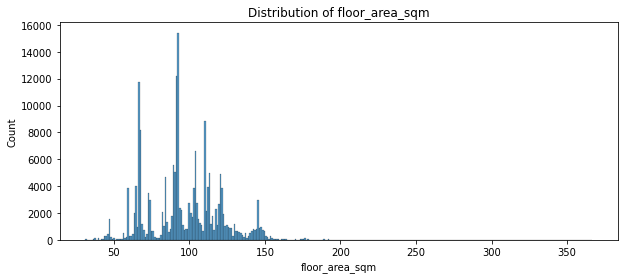

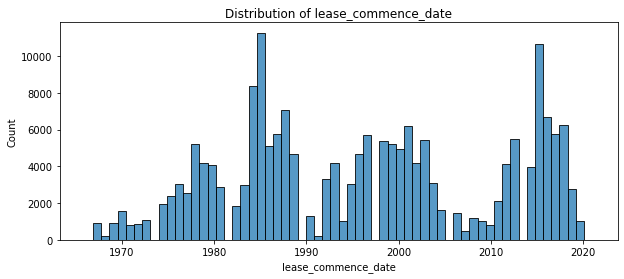

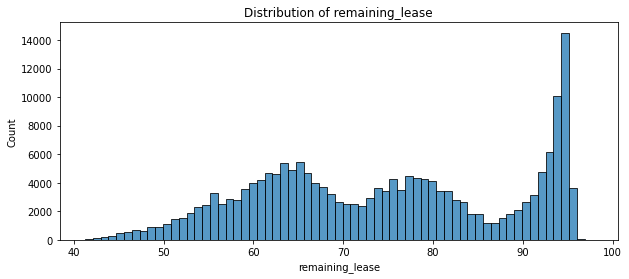

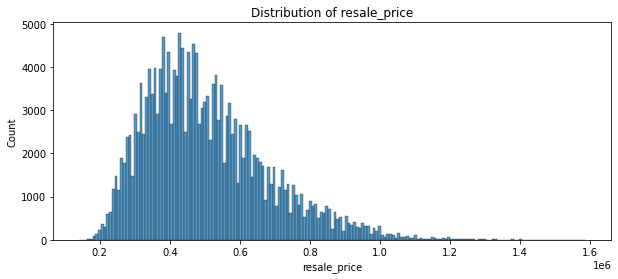

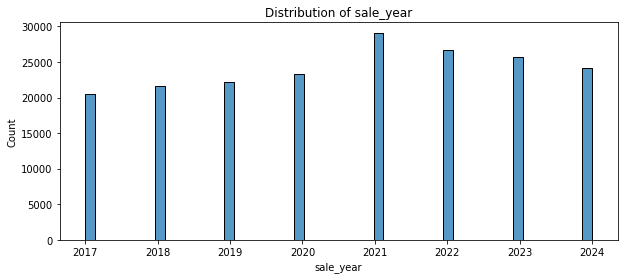

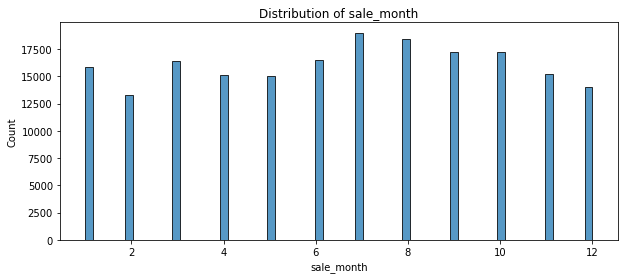

In [18]:
df[numerical_cols].describe()

#distribution plot
for num in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[num])
    plt.title(f'Distribution of {num}')
    plt.show

I think I need to do more explore on resale_price, because it seem's it has long tail

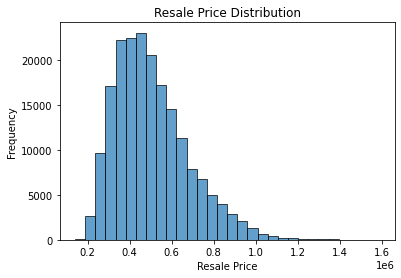

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


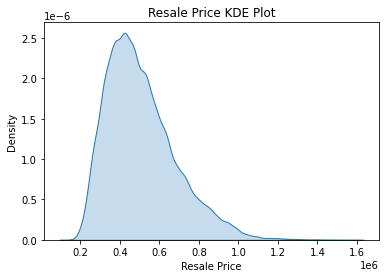

In [19]:
plt.hist(df['resale_price'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Resale Price Distribution')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')
plt.show()

#kdeplot
sns.kdeplot(df['resale_price'], fill=True)
plt.title('Resale Price KDE Plot')
plt.xlabel('Resale Price')
plt.ylabel('Density')
plt.show()

just to be sure about this, I will find the skewness and kurtosis.

Skewness is a measure of symmetry, or more precisely, the lack of symmetry. Kurtosis is a statistical measure that quantifies the shape of a probability distribution. It provides information about the tails and peakedness of the distribution compared to a normal distribution.

source:
- https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis
- https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/


In [20]:
from scipy.stats import skew, kurtosis

skewness = skew(df['resale_price'])
kurt = kurtosis(df['resale_price'])

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

Skewness: 0.9432398027453087
Kurtosis: 1.0879554071793542


because it has skewness more than 0 (>0) then it's right-skewed or we can say it has long tail on the right. but it also has kurtois less than 3 (<3). So, it's light tails or we can say it has fewer outliers

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


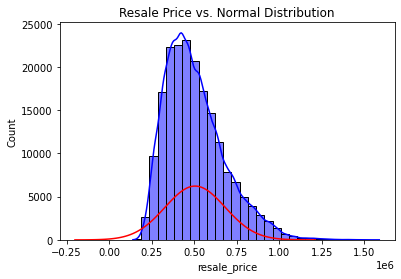

In [21]:
#now let's compare it with normal distribution

from scipy.stats import norm
import numpy as np

mean, std = df['resale_price'].mean(), df['resale_price'].std()
sns.histplot(df['resale_price'], kde=True, color='blue', bins=30)
x = np.linspace(mean - 4*std, mean + 4*std, 100)
plt.plot(x, norm.pdf(x, mean, std) * len(df['resale_price']) * (x[1]-x[0]), color='red')
plt.title('Resale Price vs. Normal Distribution')
plt.show()


So, yeah it's clear it has long tail. we need to use log1p

if we compare it side by side

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


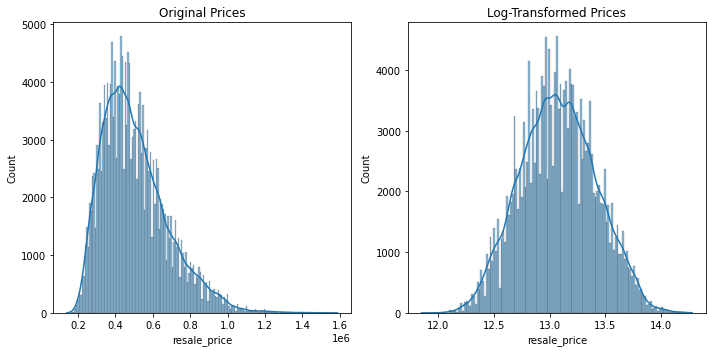

In [22]:
price_logs = np.log1p(df.resale_price)

# Plot original data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['resale_price'], kde=True)
plt.title('Original Prices')

# Plot transformed data
plt.subplot(1, 2, 2)
sns.histplot(price_logs, kde=True)
plt.title('Log-Transformed Prices')

plt.tight_layout()
plt.show()

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='resale_price_log', ylabel='Count'>

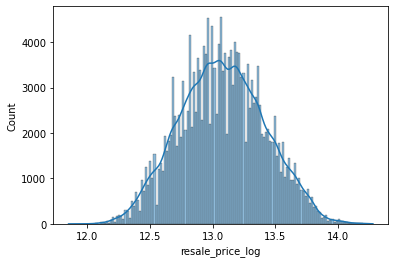

In [23]:
#now let's apply it on model (log1p)
df['resale_price_log'] = np.log1p(df['resale_price'])
sns.histplot(df['resale_price_log'], kde=True)

In [24]:
#let's take a look at the data agaian
df[['resale_price', 'resale_price_log']].head()

,resale_price,resale_price_log
0,232000.0,12.354497
1,250000.0,12.429220
2,262000.0,12.476104
3,265000.0,12.487489
4,265000.0,12.487489


let's move to categorical one


Value counts for town:
town
SENGKANG     15962
PUNGGOL      14361
WOODLANDS    13718
YISHUN       13190
TAMPINES     12943
Name: count, dtype: int64

Value counts for flat_type:
flat_type
4 ROOM       81597
5 ROOM       47871
3 ROOM       45870
EXECUTIVE    14241
2 ROOM        3562
Name: count, dtype: int64

Value counts for block:
block
2      587
1      552
8      546
9      521
101    503
Name: count, dtype: int64

Value counts for street_name:
street_name
YISHUN RING RD        2792
PUNGGOL DR            2131
BEDOK RESERVOIR RD    2046
PUNGGOL FIELD         1910
ANG MO KIO AVE 10     1852
Name: count, dtype: int64

Value counts for storey_range:
storey_range
04 TO 06    44446
07 TO 09    40522
10 TO 12    36036
01 TO 03    34155
13 TO 15    18557
Name: count, dtype: int64

Value counts for flat_model:
flat_model
Model A              67817
Improved             47472
New Generation       23926
Premium Apartment    21758
Simplified            7410
Name: count, dtype: int64


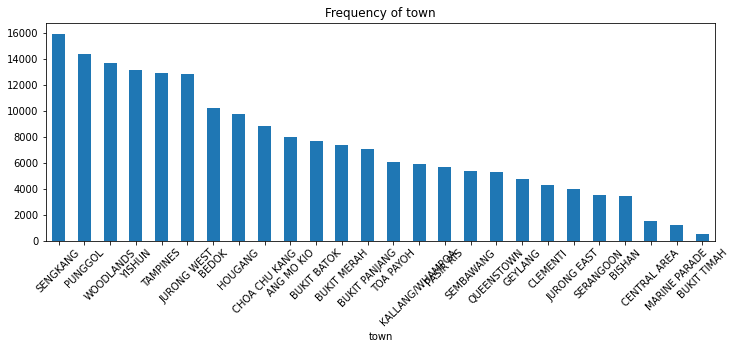

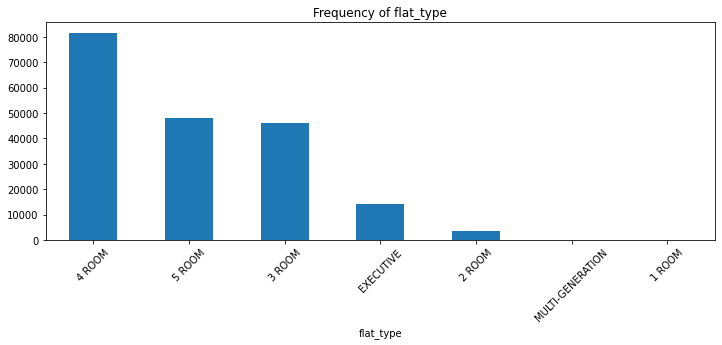

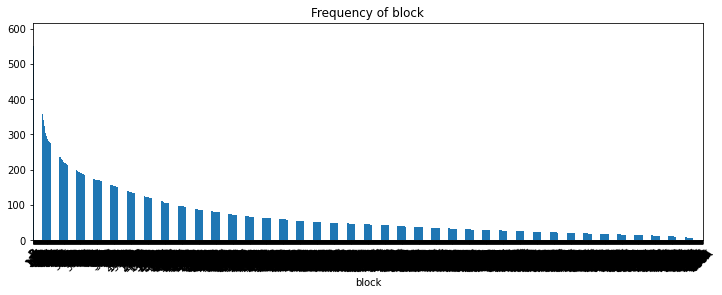

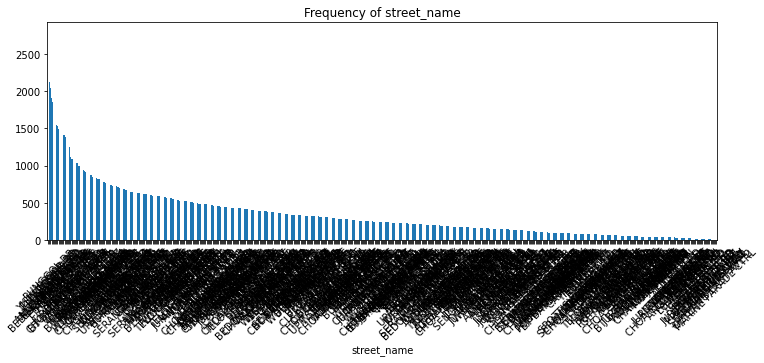

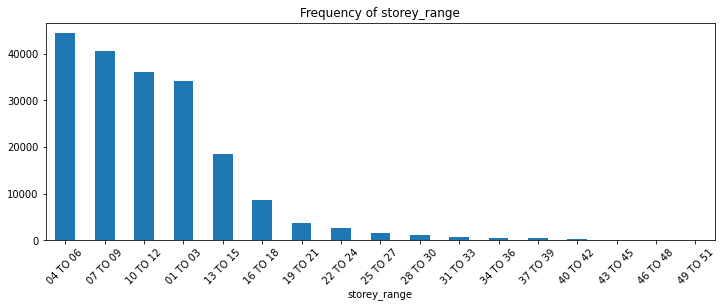

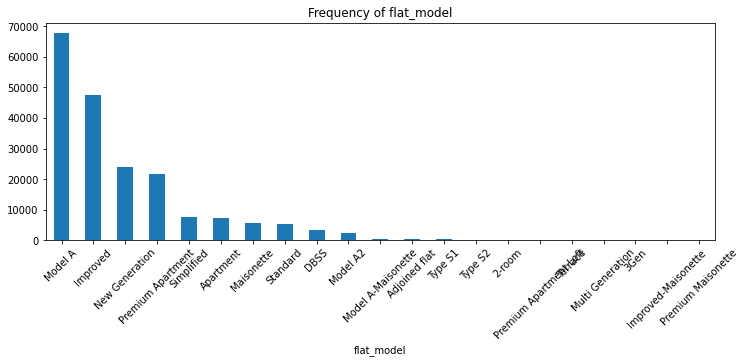

In [25]:
for cat in categorical_cols:
    print(f'\nValue counts for {cat}:')
    print(df[cat].value_counts().head())

    #bar plot
    plt.figure(figsize=(12,4))
    df[cat].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {cat}')
    plt.xticks(rotation=45)
    plt.show

let's try with distribute on categorical value

let's move to bivariate analysis

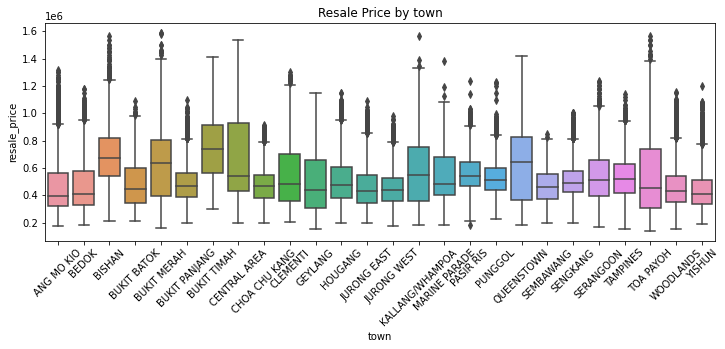

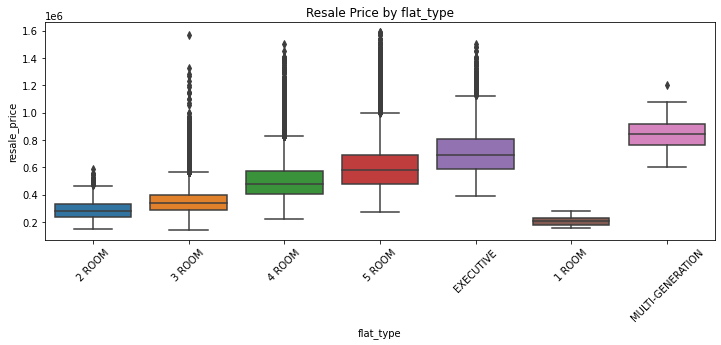

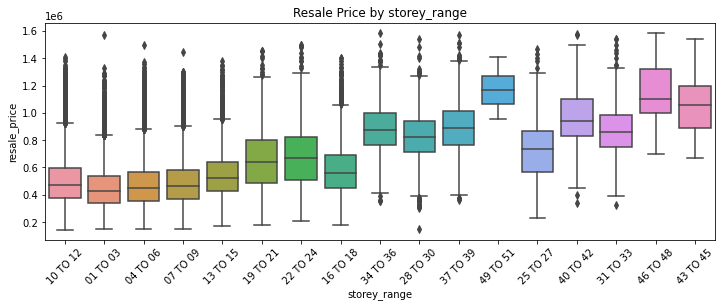

In [26]:
categorical = ['town', 'flat_type', 'storey_range']

for col in categorical:
    plt.figure(figsize=(12,4))
    sns.boxplot(data=df, x=col, y='resale_price')
    plt.xticks(rotation=45)
    plt.title(f'Resale Price by {col}')
    plt.show()

now what if we compare it with price that already gotten log1p?

In [27]:
df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'sale_date', 'sale_year',
       'sale_month', 'resale_price_log'],
      dtype='object')

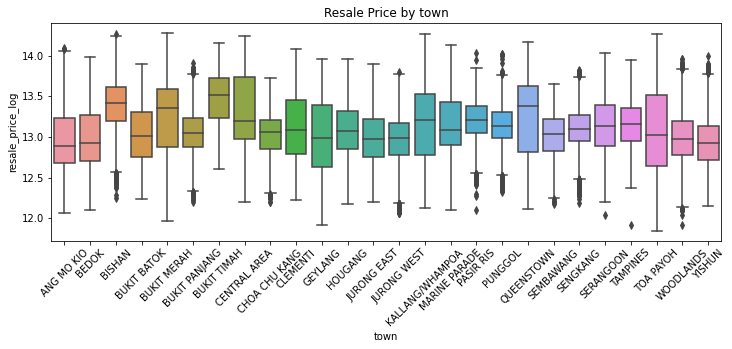

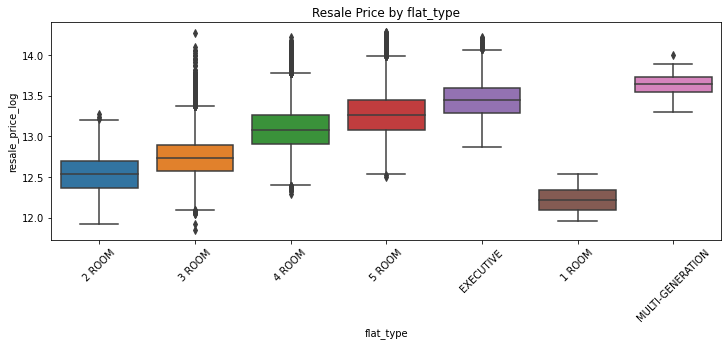

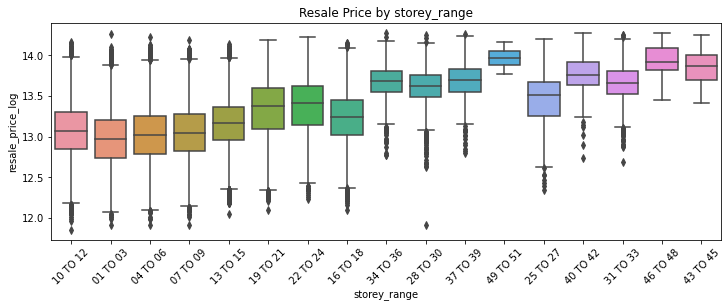

In [28]:
categorical = ['town', 'flat_type', 'storey_range']

for col in categorical:
    plt.figure(figsize=(12,4))
    sns.boxplot(data=df, x=col, y='resale_price_log')
    plt.xticks(rotation=45)
    plt.title(f'Resale Price by {col}')
    plt.show()

I think we get lesser outliers but it definetely still there

analysis month vs price

In [29]:
df[['sale_date', 'sale_month', 'sale_year']].head()

,sale_date,sale_month,sale_year
0,2017-01-01,1,2017
1,2017-01-01,1,2017
2,2017-01-01,1,2017
3,2017-01-01,1,2017
4,2017-01-01,1,2017


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


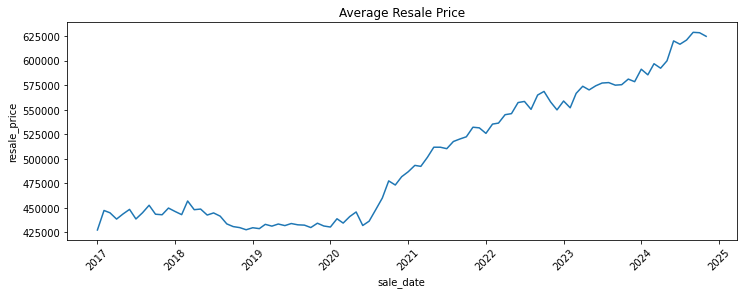

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


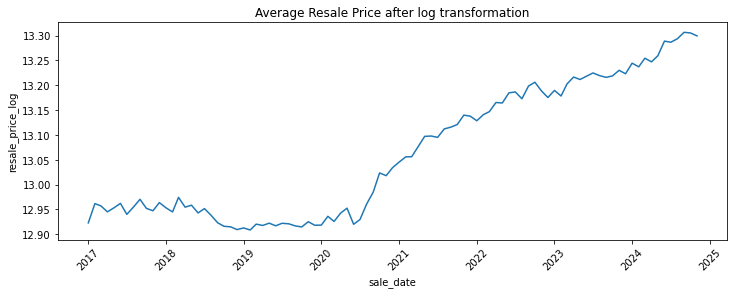

In [30]:
date_avg = df.groupby('sale_date')['resale_price'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(data=date_avg, x = 'sale_date', y='resale_price')
plt.title('Average Resale Price')
plt.xticks(rotation = 45)
plt.show()

date_avg = df.groupby('sale_date')['resale_price_log'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(data=date_avg, x = 'sale_date', y='resale_price_log')
plt.title('Average Resale Price after log transformation')
plt.xticks(rotation = 45)
plt.show()

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


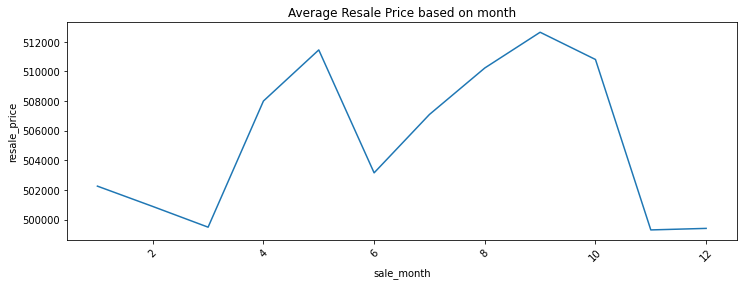

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


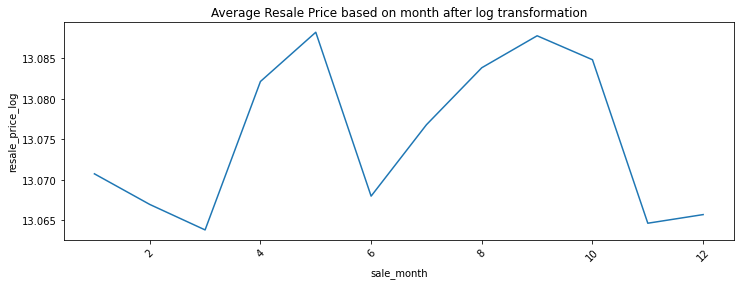

In [31]:
#based on sale_month with original price
monthly_avg = df.groupby('sale_month')['resale_price'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(data=monthly_avg, x = 'sale_month', y='resale_price')
plt.title('Average Resale Price based on month')
plt.xticks(rotation = 45)
plt.show()


monthly_avg = df.groupby('sale_month')['resale_price_log'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(data=monthly_avg, x = 'sale_month', y='resale_price_log')
plt.title('Average Resale Price based on month after log transformation')
plt.xticks(rotation = 45)
plt.show()


it has similar, now move to year vs price

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


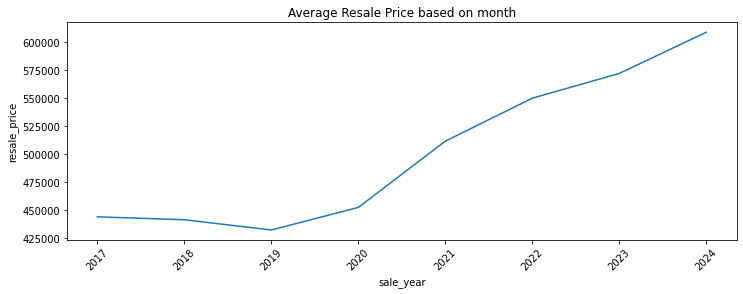

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


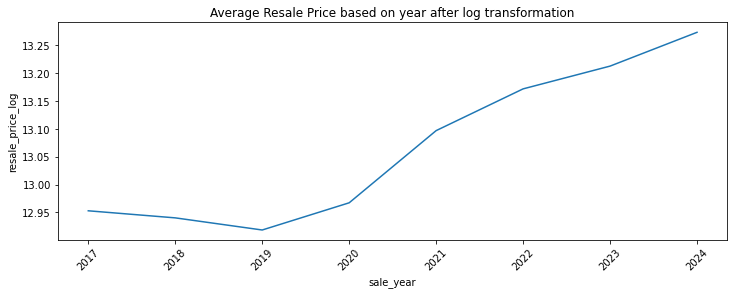

In [32]:
#based on sale_year with original price
annual_avg = df.groupby('sale_year')['resale_price'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(data=annual_avg, x = 'sale_year', y='resale_price')
plt.title('Average Resale Price based on month')
plt.xticks(rotation = 45)
plt.show()


annual_avg = df.groupby('sale_year')['resale_price_log'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(data=annual_avg, x = 'sale_year', y='resale_price_log')
plt.title('Average Resale Price based on year after log transformation')
plt.xticks(rotation = 45)
plt.show()


<Axes: xlabel='sale_month'>

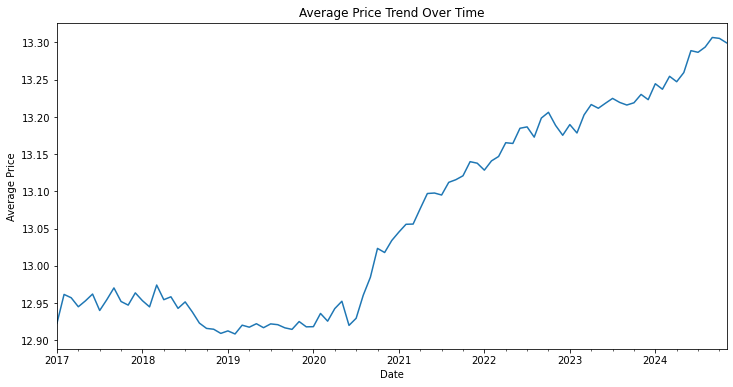

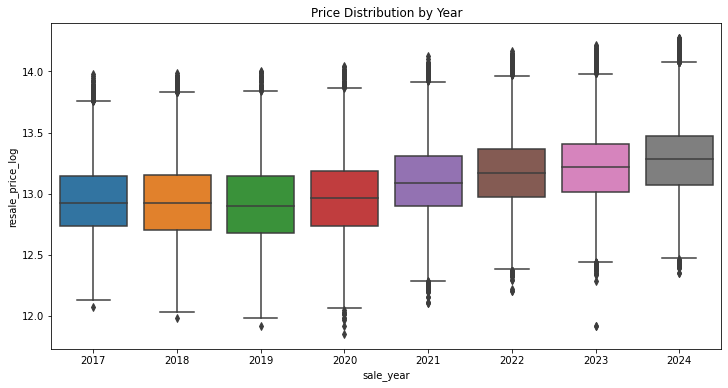

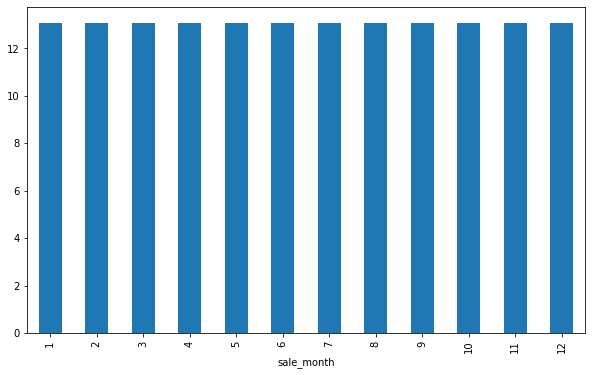

In [33]:
# 1. Plot average price trend over time
plt.figure(figsize=(12, 6))
df.groupby('sale_date')['resale_price_log'].mean().plot()
plt.title('Average Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')

# 2. Box plot of prices by year
plt.figure(figsize=(12, 6))
sns.boxplot(x='sale_year', y='resale_price_log', data=df)
plt.title('Price Distribution by Year')

# 3. Monthly seasonality
monthly_avg = df.groupby('sale_month')['resale_price_log'].mean()
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar')

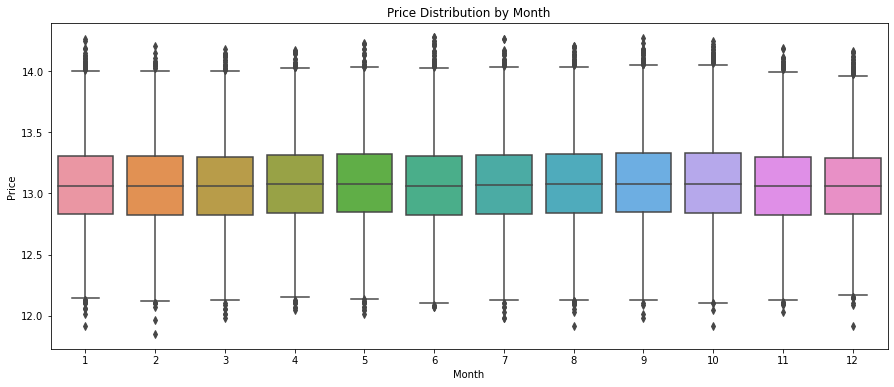

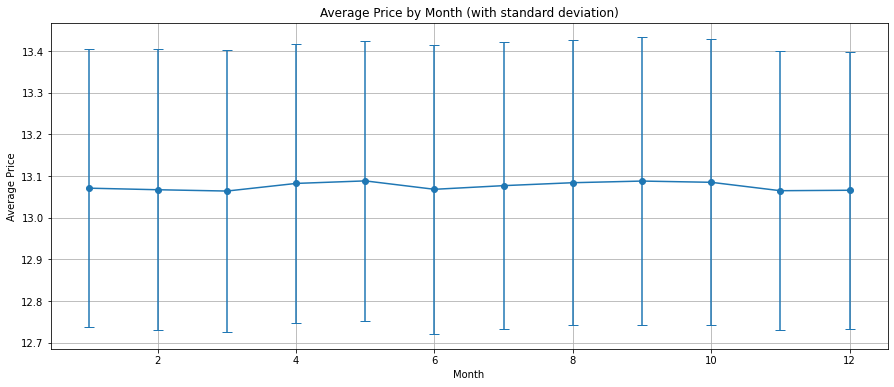


Monthly Price Summary:
            count   mean  median
sale_month                      
1           15823  13.07   13.06
2           13248  13.07   13.06
3           16402  13.06   13.06
4           15158  13.08   13.08
5           15000  13.09   13.08
6           16506  13.07   13.06
7           18997  13.08   13.07
8           18464  13.08   13.08
9           17254  13.09   13.08
10          17209  13.08   13.08
11          15229  13.06   13.06
12          14002  13.07   13.06


In [34]:
# Let's make a clearer monthly visualization
plt.figure(figsize=(15, 6))
sns.boxplot(x='sale_month', y='resale_price_log', data=df)
plt.title('Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

# Let's also look at average prices by month with error bars
plt.figure(figsize=(15, 6))
monthly_stats = df.groupby('sale_month')['resale_price_log'].agg(['mean', 'std']).reset_index()
plt.errorbar(monthly_stats['sale_month'], 
            monthly_stats['mean'], 
            yerr=monthly_stats['std'],
            fmt='o-',
            capsize=5)
plt.title('Average Price by Month (with standard deviation)')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

# Let's also print the actual numbers
monthly_summary = df.groupby('sale_month')['resale_price_log'].agg(['count', 'mean', 'median']).round(2)
print("\nMonthly Price Summary:")
print(monthly_summary)

### Cycle encoding

now, it's time to do cycle encoding. Why I use this? because in reality december (12) is closer to january (1), but if we leave them be then computer will think they are far like normal number.

also, I plan to make time trend because to help understanding the trend across 7 years(2017-2024)

In [35]:
#make cyclical month encoding.
df['month_sin'] = np.sin(2* np.pi * df['sale_month']/12)
df['month_cos'] = np.cos(2* np.pi * df['sale_month']/12)

#create time trend
df['month_since_start'] = (df['sale_date'] - df['sale_date'].min()).dt.total_seconds()/(60*60*24*30)

In [36]:
df[['month_sin', 'month_cos', 'month_since_start']]

,month_sin,month_cos,month_since_start
0,0.5,0.866025,0.000000
1,0.5,0.866025,0.000000
2,0.5,0.866025,0.000000
3,0.5,0.866025,0.000000
4,0.5,0.866025,0.000000
...,...,...,...
193287,-0.5,0.866025,95.366667
193288,-0.5,0.866025,95.366667
193289,-0.5,0.866025,95.366667
193290,-0.5,0.866025,95.366667


trying to plot resale_proce_log vs month_since_start, month_sin, month_cos

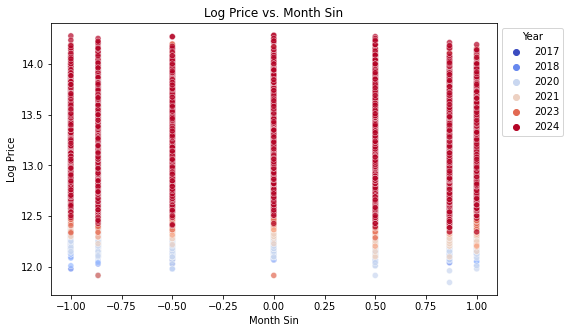

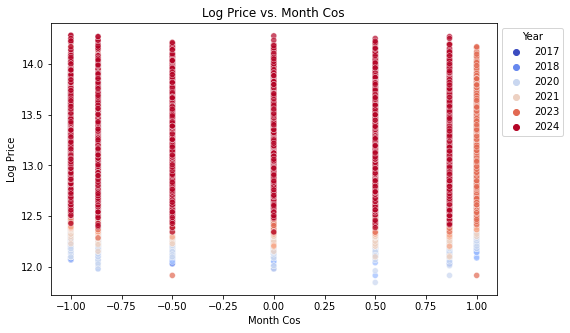

In [37]:
#  month_sin
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='month_sin', y='resale_price_log', hue='sale_year', palette='coolwarm', alpha=0.7)
plt.title('Log Price vs. Month Sin')
plt.xlabel('Month Sin')
plt.ylabel('Log Price')
plt.legend(title='Year', bbox_to_anchor=(1, 1))
plt.show()

#  month_cos
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='month_cos', y='resale_price_log', hue='sale_year', palette='coolwarm', alpha=0.7)
plt.title('Log Price vs. Month Cos')
plt.xlabel('Month Cos')
plt.ylabel('Log Price')
plt.legend(title='Year', bbox_to_anchor=(1, 1))
plt.show()


C:\Users\asus\AppData\Local\Temp/ipykernel_15280/4078074087.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='month_since_start', y='resale_price_log', ci=None)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


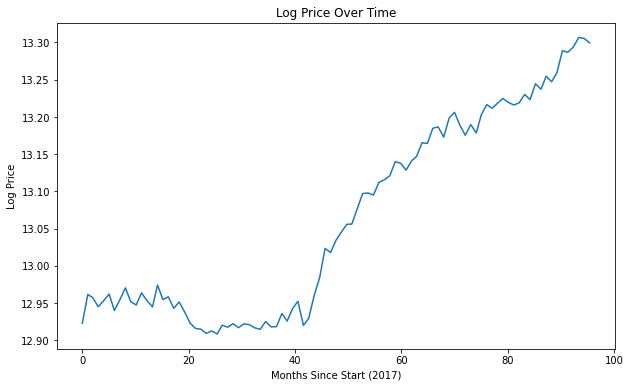

In [38]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month_since_start', y='resale_price_log', ci=None)
plt.title('Log Price Over Time')
plt.xlabel('Months Since Start (2017)')
plt.ylabel('Log Price')
plt.show()


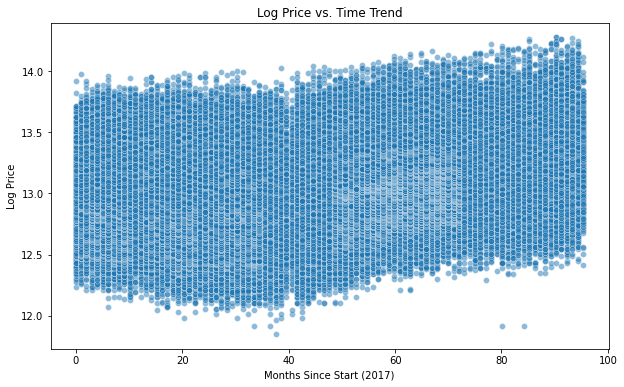

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='month_since_start', y='resale_price_log', alpha=0.5)
plt.title('Log Price vs. Time Trend')
plt.xlabel('Months Since Start (2017)')
plt.ylabel('Log Price')
plt.show()


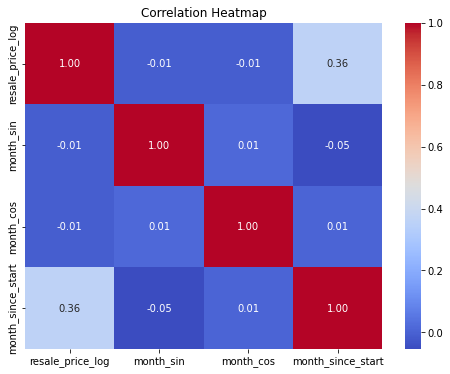

In [40]:
corr_matrix = df[['resale_price_log', 'month_sin', 'month_cos', 'month_since_start']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

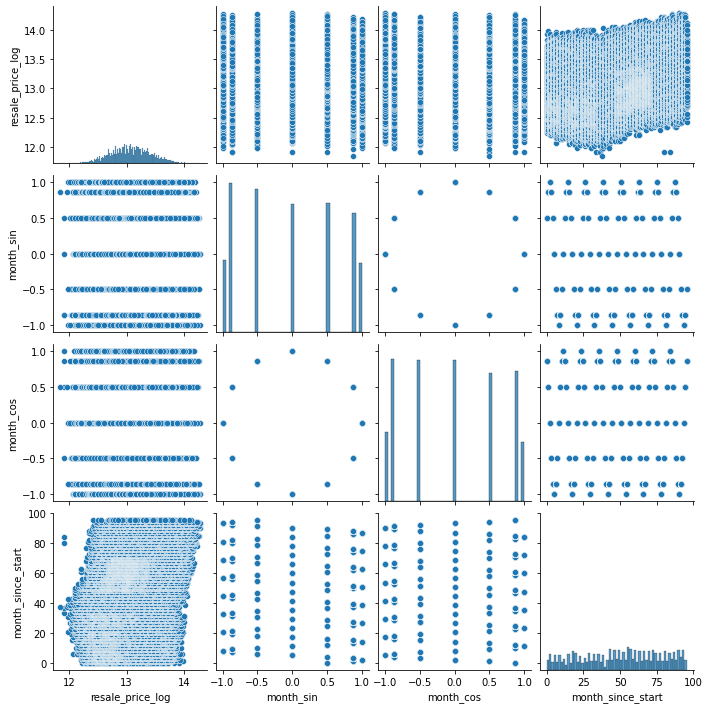

In [41]:
sns.pairplot(df, vars=['resale_price_log', 'month_sin', 'month_cos', 'month_since_start'], kind='scatter')
plt.show()


## Feature Importance

In [42]:
df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'sale_date', 'sale_year',
       'sale_month', 'resale_price_log', 'month_sin', 'month_cos',
       'month_since_start'],
      dtype='object')

In [43]:
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,sale_date,sale_year,sale_month,resale_price_log,month_sin,month_cos,month_since_start
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.33,232000.0,2017-01-01,2017,1,12.354497,0.5,0.866025,0.0
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.58,250000.0,2017-01-01,2017,1,12.429220,0.5,0.866025,0.0
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,262000.0,2017-01-01,2017,1,12.476104,0.5,0.866025,0.0
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.00,265000.0,2017-01-01,2017,1,12.487489,0.5,0.866025,0.0
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,265000.0,2017-01-01,2017,1,12.487489,0.5,0.866025,0.0


In [44]:
df.dtypes

town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                   object
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
remaining_lease               float64
resale_price                  float64
sale_date              datetime64[ns]
sale_year                       int32
sale_month                      int32
resale_price_log              float64
month_sin                     float64
month_cos                     float64
month_since_start             float64
dtype: object

Because there are too many features, I will start to select some features that likely to be important. First I'm going to drop block, street_name. why? because they have too many unique values.

In [45]:
features = ['town', 'flat_type', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'sale_year', 'month_sin', 'month_cos',
       'month_since_start']

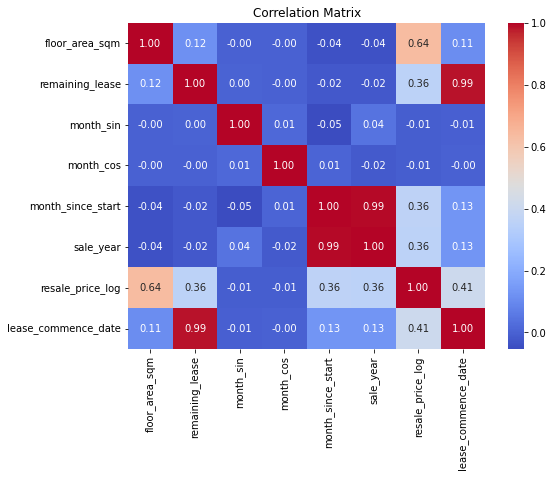

In [76]:
# find correlation between price with other numerical columns
numerical_columns = ['floor_area_sqm', 'remaining_lease', 'month_sin', 'month_cos', 'month_since_start', 'sale_year', 'resale_price_log', 'lease_commence_date']
correlation_matrix = df[numerical_columns].corr()

# Heatmap of correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

month_since_start and sale_year have high correlation and it has same score. So, i will drop sale_year too. It also happen with lease_commence_date and remaining_lease. I will use the remaining_lease instead

In [77]:
numerical_columns

['floor_area_sqm',
 'remaining_lease',
 'month_sin',
 'month_cos',
 'month_since_start',
 'sale_year',
 'resale_price_log',
 'lease_commence_date']

need to delete resale_price_log because it's the target

In [78]:
to_remove = ['sale_year', 'lease_commence_date', 'resale_price_log']

numerical_columns = list(filter(lambda x: x not in to_remove, numerical_columns))
numerical_columns

['floor_area_sqm',
 'remaining_lease',
 'month_sin',
 'month_cos',
 'month_since_start']

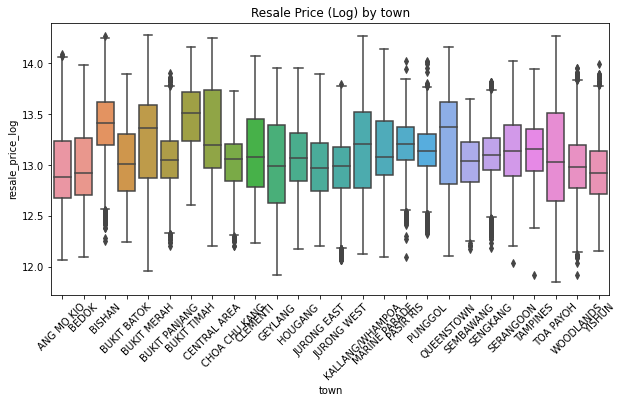

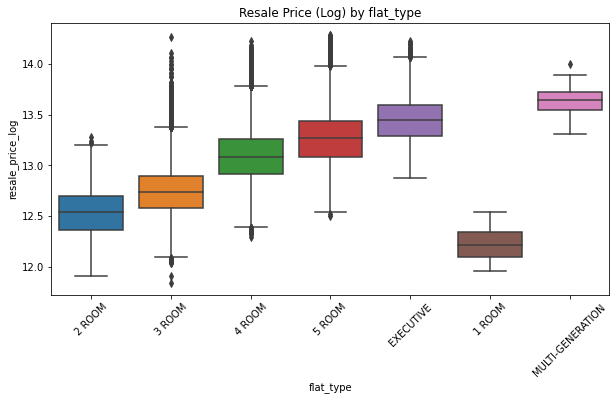

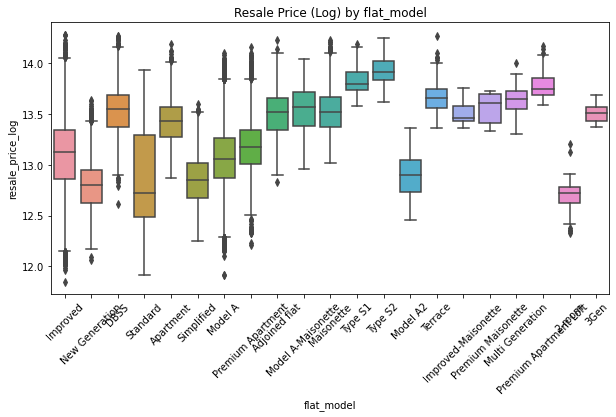

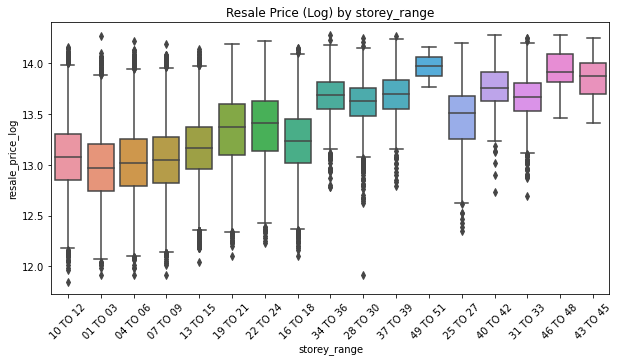

In [49]:
#categorical one

categorical_columns = ['town', 'flat_type', 'flat_model', 'storey_range']

for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=col, y='resale_price_log')
    plt.title(f'Resale Price (Log) by {col}')
    plt.xticks(rotation=45)
    plt.show()


In [50]:
for c in categorical_columns:
    print(c, round(mutual_info_score(df[c], df['resale_price_log']), 3))

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


town 0.278


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


flat_type 0.345
flat_model 0.274
storey_range 0.137


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


## Optimize data before move to the model

actually, it only for trees model (random forest, decision tree, xgboost, and lightGBM) because they makes many splits on data and I want to make it memory efficient

In [79]:
numerical_columns

['floor_area_sqm',
 'remaining_lease',
 'month_sin',
 'month_cos',
 'month_since_start']

In [51]:
categorical_columns

['town', 'flat_type', 'flat_model', 'storey_range']

In [80]:
def optimize_data(df):
    df_opt = df.copy()

    df_opt[categorical_columns] = df_opt[categorical_columns].astype('category')
    for col in numerical_columns:
        df_opt[col] = pd.to_numeric(df_opt[col], downcast='float')
    
    return df_opt

new_df = optimize_data(df)


In [81]:
new_df.dtypes

town                         category
flat_type                    category
block                          object
street_name                    object
storey_range                 category
floor_area_sqm                float32
flat_model                   category
lease_commence_date             int64
remaining_lease               float32
resale_price                  float64
sale_date              datetime64[ns]
sale_year                       int32
sale_month                      int32
resale_price_log              float64
month_sin                     float32
month_cos                     float32
month_since_start             float32
dtype: object

we don't need downcast the target, it's better to leave them be.

## Split the Dataset

train: 60%
val: 20%
test: 20%

In [83]:
#add 'resale_price_log
numerical_columns = numerical_columns  + ['resale_price_log']
numerical_columns

['floor_area_sqm',
 'remaining_lease',
 'month_sin',
 'month_cos',
 'month_since_start',
 'resale_price_log']

In [84]:
new_df[categorical_columns+numerical_columns]

,town,flat_type,flat_model,storey_range,floor_area_sqm,remaining_lease,month_sin,month_cos,month_since_start,resale_price_log
0,ANG MO KIO,2 ROOM,Improved,10 TO 12,44.0,61.330002,0.5,0.866025,0.000000,12.354497
1,ANG MO KIO,3 ROOM,New Generation,01 TO 03,67.0,60.580002,0.5,0.866025,0.000000,12.429220
2,ANG MO KIO,3 ROOM,New Generation,01 TO 03,67.0,62.419998,0.5,0.866025,0.000000,12.476104
3,ANG MO KIO,3 ROOM,New Generation,04 TO 06,68.0,62.000000,0.5,0.866025,0.000000,12.487489
4,ANG MO KIO,3 ROOM,New Generation,01 TO 03,67.0,62.419998,0.5,0.866025,0.000000,12.487489
...,...,...,...,...,...,...,...,...,...,...
193287,YISHUN,5 ROOM,Improved,10 TO 12,112.0,90.000000,-0.5,0.866025,95.366669,13.441546
193288,YISHUN,5 ROOM,Improved,10 TO 12,121.0,62.919998,-0.5,0.866025,95.366669,13.473022
193289,YISHUN,5 ROOM,Improved,04 TO 06,121.0,67.330002,-0.5,0.866025,95.366669,13.458837
193290,YISHUN,5 ROOM,Improved,01 TO 03,121.0,61.669998,-0.5,0.866025,95.366669,13.337476


In [91]:
df_full_train, df_test = train_test_split(new_df[categorical_columns+numerical_columns], test_size=0.2, random_state=42)

#split to train, test, validation
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = (df_train.resale_price_log.values)
y_test = (df_test.resale_price_log.values)
y_val = (df_val.resale_price_log.values)

del df_train['resale_price_log']
del df_test['resale_price_log']
del df_val['resale_price_log']

#check size
print("Train size:", len(df_train))
print("Validation size:", len(df_val))
print("Test size:", len(df_test))

Train size: 115974
Validation size: 38659
Test size: 38659


In [92]:
df_train.head()

,town,flat_type,flat_model,storey_range,floor_area_sqm,remaining_lease,month_sin,month_cos,month_since_start
0,SERANGOON,4 ROOM,New Generation,04 TO 06,91.0,64.250000,0.500000,8.660254e-01,36.500000
1,BEDOK,EXECUTIVE,Apartment,07 TO 09,145.0,71.669998,1.000000,6.123234e-17,87.199997
2,TAMPINES,4 ROOM,Model A,10 TO 12,104.0,67.250000,-0.500000,8.660254e-01,46.666668
3,BUKIT BATOK,5 ROOM,Improved,07 TO 09,112.0,93.500000,-0.500000,-8.660254e-01,91.266670
4,ANG MO KIO,3 ROOM,New Generation,01 TO 03,68.0,56.830002,0.866025,-5.000000e-01,76.033333


In [94]:
y_train

array([12.94801237, 13.79530887, 12.90669432, ..., 12.70685096,
       12.89922233, 13.33424535])

## Model Training

In [95]:
# Convert data to dictionary format
# DictVectorizer expects input as dictionaries
X_train_dict = df_train.to_dict(orient='records')
X_val_dict = df_val.to_dict(orient='records')
X_test_dict = df_test.to_dict(orient='records')

# Fit DictVectorizer only on the training data
dv = DictVectorizer()
X_train = dv.fit_transform(X_train_dict)

#transform
X_val= dv.transform(X_val_dict)
X_test = dv.transform(X_test_dict)

### Linear Regression

In [100]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model
val_predictions = lr_model.predict(X_val)
test_predictions = lr_model.predict(X_test)

val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)

Validation RMSE: 0.11294184381785877
Test RMSE: 0.11249644986172026


### Ridge Model

In [101]:
ridge_model = Ridge()

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

#Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  
)

# Fit the model on train + validation data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print("Validation RMSE:", val_rmse)

# Final evaluation on the test set
test_predictions = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'alpha': 1}
Validation RMSE: 0.1133557990029395
Test RMSE: 0.11294275117586196


### Decision Tree

In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)

# 
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],        # Minimum samples required at a leaf node
}


grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all processors
)

# Fit the model on train + validation data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print("Validation RMSE:", val_rmse)

# Final evaluation on the test set
test_predictions = best_model.predict(X_test)
test_mse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 5}
Validation RMSE: 0.09417010173928707
Test RMSE: 0.11294275117586196


### Random Forest

In [108]:
rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [5, 10, 15, 20],      # Number of trees
    'max_depth': [5, 10, 15, 20],      # Maximum depth of trees    
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1 
)

# Fit the model on train + validation data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print("Validation RMSE:", val_rmse)

# Final evaluation on the test set
test_predictions = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 20}
Validation RMSE: 0.08444179419029049
Test RMSE: 0.08437876574101712


### XGBoost Model

In [109]:
xgb_reg = XGBRegressor(random_state=42)

param_grid = {
    'eta': [0.1, 0.3, 0.5, 0.7],
    'max_depth': [5, 10, 15, 20, 25, 50],        
}

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1 
)

# Fit the model on train + validation data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print("Validation RMSE:", val_rmse)

# Final evaluation on the test set
test_predictions = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'eta': 0.1, 'max_depth': 15}
Validation RMSE: 0.0668582255736014
Test RMSE: 0.06704851195079392


### LightGBM

In [111]:
lgb_reg = LGBMRegressor(random_state=42)

param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 0.7],
    'max_depth': [5, 10, 15, 20, 25, 50],        
}

grid_search = GridSearchCV(
    estimator=lgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1 
)

# Fit the model on train + validation data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print("Validation RMSE:", val_rmse)

# Final evaluation on the test set
test_predictions = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 115974, number of used features: 72
[LightGBM] [Info] Start training from score 13.076112
Best Parameters: {'learning_rate': 0.3, 'max_depth': 10}
Validation RMSE: 0.07363337695202878
Test RMSE: 0.07342504700520996


I didn't expect LightGBM that run that fast. I mean it only running for 36.7s.

FYI, here are comparisson of their time for running model and the results:
- Linear Regresion: 0.122 both validation and test with time around 0.5s
- Ridge: 0.113 on validation and 0.112 on test with time around 8.6s
- Decision Tree: 0.094 on validation and 0.113 on test with time around 31.9s
- Random Forest: 0.084 on validation and 0.084 on test with time more than 12 minutes
- XGBoost: 0.067 on validation and 0.066 on test with time more than 9 minutes.

Lastly, LightGBM: 0.073 both validation and test with time needed only 36.7s.

I mean from this comparison I will choose LightGBM. not only that, actually I didn't deal with outliers and imbalance data on earlier before moving too modelling because I was overwhelmed. Usually trees model good handling that two of problem. So, model choosen is LightGBM

## Selected Model

In [112]:
final_model = LGBMRegressor(random_state=42,
                            learning_rate=0.3,
                            max_depth=10,
                            n_jobs=-1)

# Fit the model on train + validation data
final_model.fit(X_train, y_train)

# Evaluate on the validation set
val_predictions = final_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print("Validation RMSE:", val_rmse)

# Final evaluation on the test set
test_predictions = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print("Test RMSE:", test_rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 115974, number of used features: 72
[LightGBM] [Info] Start training from score 13.076112
Validation RMSE: 0.07363337695202878
Test RMSE: 0.07342504700520996


next, let's move to the production!